In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


In [5]:
df = yf.download('TSLA').reset_index()
df = df[(df['Date'] >= "2015-01-01") & (df['Date'] <= "2023-03-12")].reset_index(drop=True)


[*********************100%%**********************]  1 of 1 completed


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


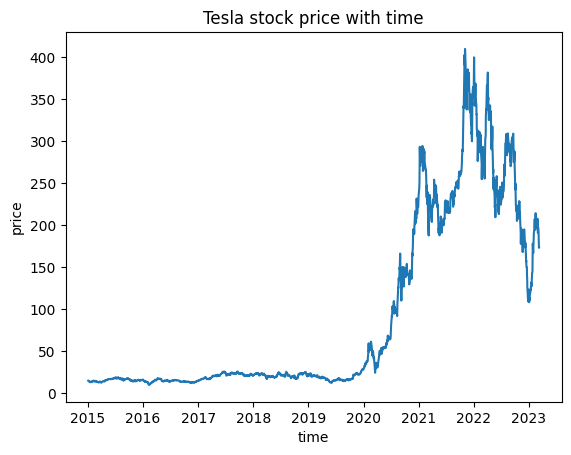

In [7]:
plt.plot(df["Date"],df["Close"])
plt.title("Tesla stock price with time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_values'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

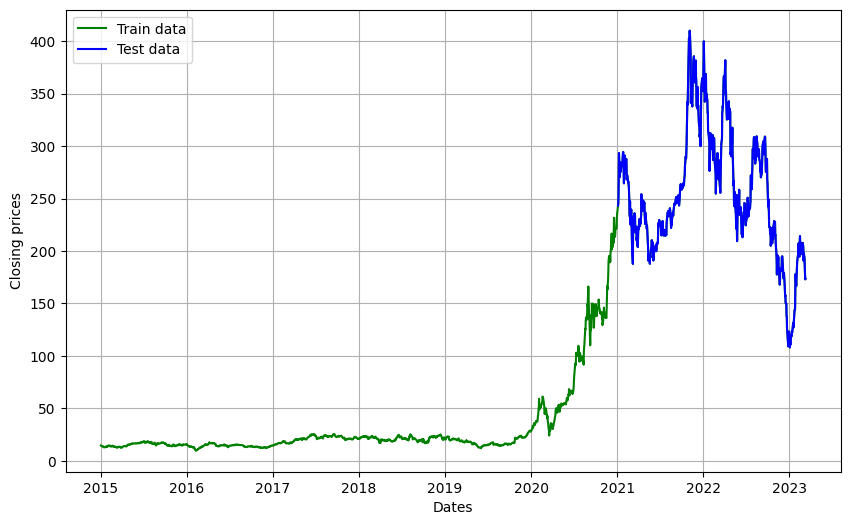

In [9]:
train_data=df[df['Date']<'2020-01-01']
test_data=df[df['Date']>='2021-01-01']

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing prices')
plt.plot(df['Date'],df['Close'],'green',label='Train data')
plt.plot(test_data['Date'],test_data['Close'],'blue',label='Test data')
plt.legend()

In [10]:
x_train = []
y_train = []

for i in range(60, len(train_data['scaled_values'])):
    x_train.append(train_data['scaled_values'][i-60:i])
    y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [11]:
x_test=[]
y_test=test_data['scaled_values']

for i in range(60,len(test_data)):
    x_test.append(test_data['scaled_values'][i-60:i])

x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [15]:
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
model.fit(x_train,y_train,epochs=10,batch_size=32)

ValueError: You must call `compile()` before using the model.

In [17]:
predicted_stock_price=model.predict(x_test)
pridicted_stock_price=scaler.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


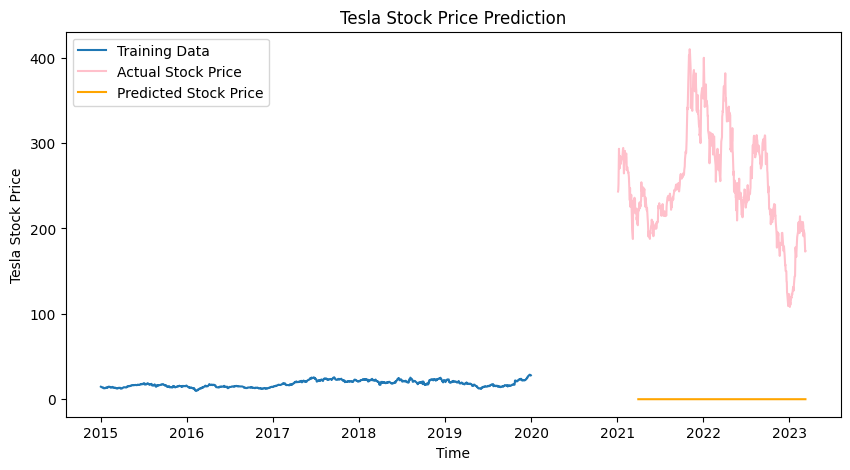

In [18]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(train_data['Date'],train_data['Close'],label='Training Data')
plt.plot(test_data['Date'],test_data['Close'],color='pink',label='Actual Stock Price')
plt.plot(test_data[60:]['Date'],predicted_stock_price,color='orange',label='Predicted Stock Price')

plt.title("Tesla Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc='upper left',fontsize=10)
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error
import math

y_true=test_data[60:]['Close'].values
y_pred=predicted_stock_price

mse=mean_squared_error(y_true,y_pred)
print('MSE:'+str(mse))
mae=mean_absolute_error(y_true,y_pred)
print('MAE:'+str(mae))
rmse=math.sqrt(mean_absolute_error(y_true,y_pred))
print('RMSE:'+str(rmse))
mape=np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
print('MAPE:'+str(mape))

MSE:68436.09780998078
MAE:253.98577071672725
RMSE:15.936931031937336
MAPE:1.0000712005548704
